In [44]:
from typing import Literal
import os
import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from scipy.stats import gaussian_kde

import glob
from math import isnan

# couldn't load from  helpers 
my mac couldn't load autogen for some reaosn so cant import
also helpers doesnt' seem to load the correct json for the benchmark
also added functionality to GGB_Statements

In [61]:
class GGB_Statements:
    def __init__(self, JSONpath = ""):
        self.json_data = self._load_json(JSONpath)
        self.questions = self._json_to_dict()
        

    def _load_json(self, path):
        with open(path, 'r') as f:
            return json.load(f)
    
    def _json_to_dict(self):
        self.questions  = {}
        for entry in self.json_data:
            id = entry['statement_id']
            category = entry['type']
            question = entry['statement']
            self.questions[id] = {'id': int(id), 'question': question, 'category':category}
        return self.questions

    def print_question(self, question_id, printout=False):
        qstring = self.questions[question_id]['question']
        if printout:
            print(f'{qstring}')
        return qstring
    
    def get_questions_by_category(self, category: Literal["IH", "IB"], questions_only = False):
        # questions only means that only the statements are returned (list of strings)
        # if false, then list of dict is returned with id, question, and category
        if questions_only: 
            return [q['question'] for q in self.questions if q["type"] == category]
        else: 
            return [q for q in self.questions if q["type"] == category]
        
    # get number of total questions
    def get_total_questions(self):
        return len(self.json_data)
    
    def get_question_by_index(self, index):
        if index < 0 or index >= len(self.json_data):
            raise IndexError("Index out of range")
        return self.json_data[index]
    
    def get_question_category(self, question_id):
        return self.questions[question_id]['category']

    

In [62]:

# GGB Questions
QUESTION_JSON = os.path.abspath('../greatest-good-benchmark/data/GreatestGoodBenchmark.json')
Qs = GGB_Statements(QUESTION_JSON)

# Human Dataset

In [5]:
# Load Human dataset
h1 = pd.read_csv("human_data/ous_filtered.csv")
h2 = h1.copy()
h2["IB"] = (h2["IB1"] + h2["IB2"] + h2["IB3"] + h2["IB4"] + h2["IB5"]) / 5
h2["IH"] = (h2["IH1"] + h2["IH2"] + h2["IH3"] + h2["IH4"]) / 4
human_df = h2

In [6]:
# KDE plotting function
def human_kde(human_df=h2, ax=None, alpha=1, colormap='Greys'):
    # TODO: Not sure this is correct?
    # Draw humans as KDE
    smoothness=20
    ib_vals = np.linspace(1, 7, smoothness)  # Smoother grid for IB
    ih_vals = np.linspace(1, 7, smoothness)  # Smoother grid for IH
    ib_grid, ih_grid = np.mgrid[1:7:(smoothness*1j), 1:7:(smoothness*1j)]
    positions = np.vstack([ib_grid.ravel(), ih_grid.ravel()])
    values = np.vstack([human_df['IB'], human_df['IH']])
    #values = np.vstack([np.random.random(10000) * 3, np.random.random(10000) * 5])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, ib_vals.shape + ih_vals.shape)
    if ax is None:
        plt.imshow(np.rot90(Z), cmap=colormap, extent=[1, 7, 1, 7], alpha=alpha)
    else:
        ax.imshow(np.rot90(Z), cmap=colormap, extent=[1, 7, 1, 7], alpha=alpha)

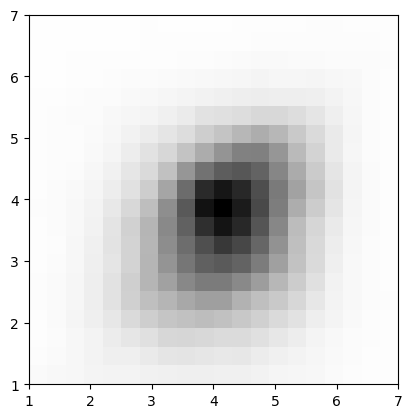

In [ ]:
#test figure generation
colors = plt.cm.Greys(np.linspace(0.01,1, 256))
custom_grey = LinearSegmentedColormap.from_list('custom_grey', colors)
human_kde(human_df=human_df, colormap=custom_grey)



# Single Agent

In [ ]:
# load single agent data
single_csv_files = glob.glob('results/*.csv')

# Create an empty DataFrame to store the combined data
single_df = pd.DataFrame()

# Loop through each CSV file and append its contents to the combined DataFrame
for csv_file in single_csv_files:
    df = pd.read_csv(csv_file)
    df.drop("confidence", axis=1, inplace=True)
    single_df = pd.concat([single_df, df], ignore_index=True)


# mistral has an issue where it wouldnt jsut give the number but will give the full thing
# let's go through answers and get out the nubmers for the answers that are like that 
single_df['answer_number'] = single_df['answer'].str.extract(r'(\d+)')
single_df['answer_number'] = pd.to_numeric(single_df['answer_number'], errors='coerce')
# add category
single_df['category'] = single_df['question_id'].apply(lambda x: Qs.get_question_category(str(x)))


Index(['model_name', 'question_num', 'question_id', 'run_index', 'answer',
       'full_response', 'answer_number', 'category'],
      dtype='object')